In [1]:
from  model.seriesNet_torch import *
import model.seriesNet_torch as SN_torch
import SeriesNetTrainTestManager
from model.seriesNet_torch import seriesNet 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import torch
import random
#import glob
from data_set.action_500FN import action, load_dataset
import matplotlib.pyplot as plt
#%matplotlib notebook
import data_set.fn_500_dataset as fn_500_dataset
from data_set.fn_500_dataset import ActionDataset
from torch.utils.data import DataLoader
import importlib
import SeriesNetTrainTestManager as SNTTM
import CausalTrainTest
import itertools
from CausalTrainTest import TrainManager

train_window :  torch.Size([787, 1, 256])
target_train :  torch.Size([787, 1, 1])
eval_train :  torch.Size([196, 1, 256])
eval_target :  torch.Size([196, 1, 1])
test_input :  torch.Size([1, 1, 256])
test_target :  torch.Size([1, 1, 20])
196
787
epoch 0/ 7
epoch 1/ 7
epoch 2/ 7
epoch 3/ 7
epoch 4/ 7
epoch 5/ 7
epoch 6/ 7


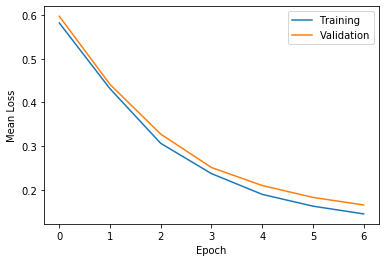

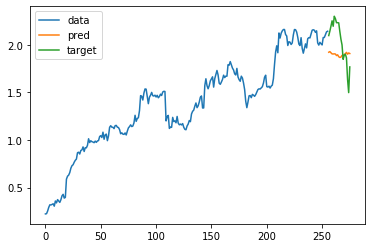

In [11]:
importlib.reload(data_set.fn_500_dataset)
importlib.reload(SN_torch)
importlib.reload(CausalTrainTest)
#dataset=fn_500_dataset.slidingWindowDataset(60,action_name='ABBV_data',axis='volume',normalise=False)

model = SN_torch.seriesNet(1, nb_causal_block=8,gate_nb_filter=16, nb_block_dropped=2)
model.float()

N = model.get_pts_for_Pred()
pts_2_pred = 20
dataset_train, dataset_eval, test_input, test_target = data_set.fn_500_dataset.create_sliding_dataset(N,
                                                                    pts_2_pred = pts_2_pred,
                                                                    action_name='AAPL_data',
                                                                    axis='open',
                                                                    normalise=True)

train_loader = DataLoader(dataset_train, batch_size=10, shuffle=False, drop_last=False)
valid_loader = DataLoader(dataset_eval, batch_size=10, shuffle=False, drop_last=False)


manager =CausalTrainTest.TrainManager( model,
                     train_loader,
                     valid_loader,
                     lr=0.001,
                     loss_fn = 'MeanSquared',
                     optimizer_type='sgd',
                     pts_2pred = 10)

manager.train(7)
manager.plot_prediction(test_input, test_target, pts_2_pred)


In [107]:
!python train.py --company=HOLX_data --num_epochs=7 --pts_2_pred=20 --save --figname=blk8_20pt_HOLX_32f_schTr

False
Training seriesNet for 7 epochs
Figure(640x480)
Figure(640x480)


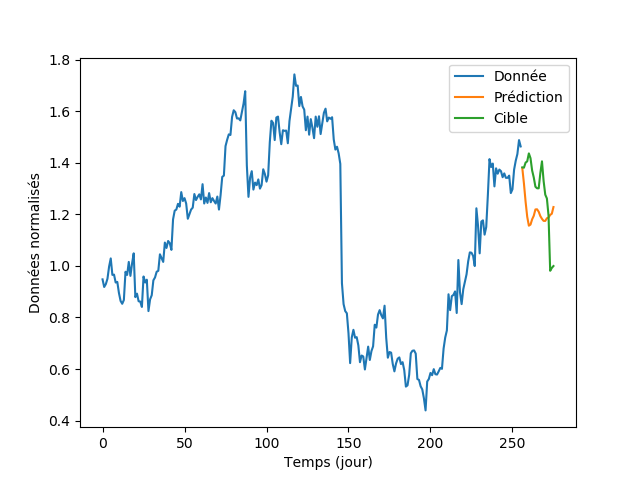

In [108]:
from IPython.display import Image
Image(filename='blk8_20pt_HOLX_32f_schTr_pred.png')  

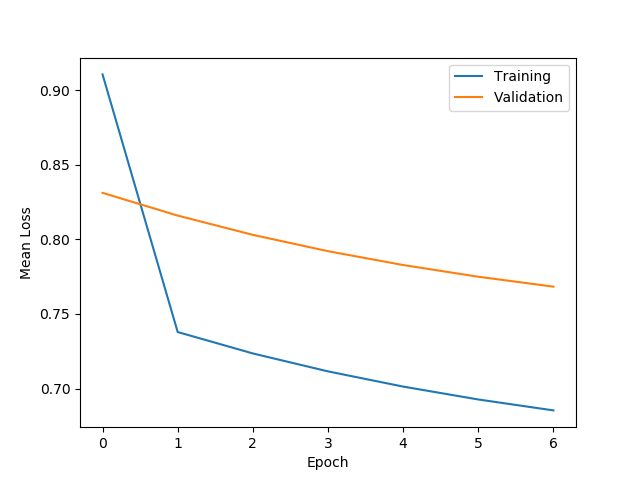

In [76]:
Image(filename='blk8_20pt_AAPL_32f_schTr_metric.png')

In [6]:
!python hyper_search_SN.py --company=AAPL_data --nb_causal_blk 5  --nb_filter 16  --nb_drop_blk 3  --lr 0.001

 IPython

Tools for Interactive Computing in Python

    A Python shell with automatic history (input and output), dynamic object
    introspection, easier configuration, command completion, access to the
    system shell and more.  IPython can also be embedded in running programs.

Usage

    ipython [subcommand] [options] [-c cmd | -m mod | file] [--] [arg] ...

    If invoked with no options, it executes the file and exits, passing the
    remaining arguments to the script, just as if you had specified the same
    command with python. You may need to specify `--` before args to be passed
    to the script, to prevent IPython from attempting to parse them. If you
    specify the option `-i` before the filename, it will enter an interactive
    IPython session after running the script, rather than exiting. Files ending
    in .py will be treated as normal Python, but files ending in .ipy can
    contain special IPython syntax (magic commands, shell expansions, etc.).

    Almost all 

[TerminalIPythonApp] WARNING | Unrecognized alias: '--company=AAPL_data', it will probably have no effect.
[TerminalIPythonApp] CRITICAL | Bad config encountered during initialization:
[TerminalIPythonApp] CRITICAL | Unrecognized flag: '--nb_causal_blk'


In [22]:

nb_causal_blk = [5, 6, 7, 8, 9]
learning_rate = np.random.choice(np.arange(1,11),3,replace=False)/10000
nb_filter = [16, 24, 32]
nb_drop_blk = [2, 3, 4]
optimizer=['sgd', 'Adam']
batch_size = 15
num_epochs = 7
#val_percent = args.validation
channel_2_use = 'close'
pts_2_pred = 15
company = 'AAPL_data'
validation = 20
shuffle = False
result={}

for causal_b, lr, filter, drop_blk,opti in itertools.product(nb_causal_blk, learning_rate, nb_filter, nb_drop_blk, optimizer ):
    converge = False
    print("Training for causal_b : {}, lr : {}, filter : {}, drop_blk : {}, opti : {}".format(causal_b, lr, filter, drop_blk,opti))
    
    while not converge:
        model = seriesNet(1, nb_causal_block=causal_b, gate_nb_filter=filter, nb_block_dropped=drop_blk)
        model.float()
        N = model.get_pts_for_Pred()
        dataset_train, dataset_eval, test_input, test_target = fn_500_dataset.create_sliding_dataset(N,
                                                                            pts_2_pred=pts_2_pred,
                                                                            proportion=validation,
                                                                            action_name=company,
                                                                            axis=channel_2_use,
                                                                            normalise=True)

        train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=shuffle, drop_last=False)
        valid_loader = DataLoader(dataset_eval, batch_size=batch_size, shuffle=shuffle, drop_last=False)

        manager = TrainManager(model,
                               train_loader,
                               valid_loader,
                               lr=lr,
                               loss_fn='MeanSquared',
                               optimizer_type=opti,
                               pts_2pred=pts_2_pred)

        manager.train(num_epochs,display=False)
        pred = manager.predict(test_input, test_target)
        if len(np.unique(pred)) != 1:
            converge=True
            loss= np.mean((test_target.view(-1).detach().numpy() - pred)**2)
            result[(causal_b, lr, filter, drop_blk,opti)]= loss
        else:
            print('problemo')

print("Combinaison gagnante : ", max(result, key=result.get) )

Training for causal_b : 5, lr : 0.001, filter : 16, drop_blk : 2, opti : sgd
problemo
Training for causal_b : 5, lr : 0.001, filter : 16, drop_blk : 2, opti : Adam
Training for causal_b : 5, lr : 0.001, filter : 16, drop_blk : 3, opti : sgd
Training for causal_b : 5, lr : 0.001, filter : 16, drop_blk : 3, opti : Adam
Training for causal_b : 5, lr : 0.001, filter : 16, drop_blk : 4, opti : sgd
Training for causal_b : 5, lr : 0.001, filter : 16, drop_blk : 4, opti : Adam
problemo
Training for causal_b : 5, lr : 0.001, filter : 24, drop_blk : 2, opti : sgd
problemo
problemo
Training for causal_b : 5, lr : 0.001, filter : 24, drop_blk : 2, opti : Adam
Training for causal_b : 5, lr : 0.001, filter : 24, drop_blk : 3, opti : sgd
Training for causal_b : 5, lr : 0.001, filter : 24, drop_blk : 3, opti : Adam
Training for causal_b : 5, lr : 0.001, filter : 24, drop_blk : 4, opti : sgd
problemo
Training for causal_b : 5, lr : 0.001, filter : 24, drop_blk : 4, opti : Adam
Training for causal_b : 5

Training for causal_b : 6, lr : 0.0004, filter : 24, drop_blk : 4, opti : sgd
Training for causal_b : 6, lr : 0.0004, filter : 24, drop_blk : 4, opti : Adam
Training for causal_b : 6, lr : 0.0004, filter : 32, drop_blk : 2, opti : sgd
Training for causal_b : 6, lr : 0.0004, filter : 32, drop_blk : 2, opti : Adam
Training for causal_b : 6, lr : 0.0004, filter : 32, drop_blk : 3, opti : sgd
Training for causal_b : 6, lr : 0.0004, filter : 32, drop_blk : 3, opti : Adam
Training for causal_b : 6, lr : 0.0004, filter : 32, drop_blk : 4, opti : sgd
Training for causal_b : 6, lr : 0.0004, filter : 32, drop_blk : 4, opti : Adam
Training for causal_b : 7, lr : 0.001, filter : 16, drop_blk : 2, opti : sgd
problemo
problemo
problemo
problemo
Training for causal_b : 7, lr : 0.001, filter : 16, drop_blk : 2, opti : Adam
Training for causal_b : 7, lr : 0.001, filter : 16, drop_blk : 3, opti : sgd
Training for causal_b : 7, lr : 0.001, filter : 16, drop_blk : 3, opti : Adam
Training for causal_b : 7,

Training for causal_b : 8, lr : 0.0008, filter : 32, drop_blk : 4, opti : sgd
problemo
Training for causal_b : 8, lr : 0.0008, filter : 32, drop_blk : 4, opti : Adam
Training for causal_b : 8, lr : 0.0004, filter : 16, drop_blk : 2, opti : sgd
problemo
Training for causal_b : 8, lr : 0.0004, filter : 16, drop_blk : 2, opti : Adam
Training for causal_b : 8, lr : 0.0004, filter : 16, drop_blk : 3, opti : sgd
Training for causal_b : 8, lr : 0.0004, filter : 16, drop_blk : 3, opti : Adam
Training for causal_b : 8, lr : 0.0004, filter : 16, drop_blk : 4, opti : sgd
problemo
Training for causal_b : 8, lr : 0.0004, filter : 16, drop_blk : 4, opti : Adam
problemo
problemo
Training for causal_b : 8, lr : 0.0004, filter : 24, drop_blk : 2, opti : sgd
Training for causal_b : 8, lr : 0.0004, filter : 24, drop_blk : 2, opti : Adam
problemo
Training for causal_b : 8, lr : 0.0004, filter : 24, drop_blk : 3, opti : sgd
Training for causal_b : 8, lr : 0.0004, filter : 24, drop_blk : 3, opti : Adam
prob

In [109]:
result

{(5, 0.001, 16, 2, 'sgd'): 0.12760962202122908,
 (5, 0.001, 16, 2, 'Adam'): 0.06672052914134857,
 (5, 0.001, 16, 3, 'sgd'): 2.3808968423632026,
 (5, 0.001, 16, 3, 'Adam'): 1.991125393071345,
 (5, 0.001, 16, 4, 'sgd'): 2.4054364778498893,
 (5, 0.001, 16, 4, 'Adam'): 3.8612958466520704,
 (5, 0.001, 24, 2, 'sgd'): 0.7655813446758628,
 (5, 0.001, 24, 2, 'Adam'): 2.133296752992614,
 (5, 0.001, 24, 3, 'sgd'): 0.03236626399855614,
 (5, 0.001, 24, 3, 'Adam'): 0.15377187179410706,
 (5, 0.001, 24, 4, 'sgd'): 2.409932104217057,
 (5, 0.001, 24, 4, 'Adam'): 1.0510785343613656,
 (5, 0.001, 32, 2, 'sgd'): 0.008905918263424913,
 (5, 0.001, 32, 2, 'Adam'): 1.7719805889823945,
 (5, 0.001, 32, 3, 'sgd'): 0.12374663271540763,
 (5, 0.001, 32, 3, 'Adam'): 0.07615954460020476,
 (5, 0.001, 32, 4, 'sgd'): 0.10751175805569062,
 (5, 0.001, 32, 4, 'Adam'): 0.46856557369940693,
 (5, 0.0008, 16, 2, 'sgd'): 4.810507176217073,
 (5, 0.0008, 16, 2, 'Adam'): 4.226568088830112,
 (5, 0.0008, 16, 3, 'sgd'): 0.2293187853407

In [21]:
model = seriesNet(1, nb_causal_block=9, gate_nb_filter=16, nb_block_dropped=3)
model.float()
N = model.get_pts_for_Pred()
np.random.choice(np.arange(1,11),3,replace=False)/10000

array([0.0003, 0.001 , 0.0006])

<class 'int'>
<class 'int'> <class 'int'>
32



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 of 10



 10%|█         | 1/10 [00:08<01:13,  8.19s/it]

Epoch: 2 of 10



 20%|██        | 2/10 [00:16<01:06,  8.31s/it]

Epoch: 3 of 10



 30%|███       | 3/10 [00:25<00:58,  8.34s/it]

Epoch: 4 of 10



 40%|████      | 4/10 [00:33<00:50,  8.38s/it]

Epoch: 5 of 10



 50%|█████     | 5/10 [00:41<00:40,  8.15s/it]

Epoch: 6 of 10



 60%|██████    | 6/10 [00:48<00:31,  7.89s/it]

Epoch: 7 of 10



 70%|███████   | 7/10 [00:57<00:24,  8.26s/it]

Epoch: 8 of 10



 80%|████████  | 8/10 [01:06<00:17,  8.56s/it]

Epoch: 9 of 10



 90%|█████████ | 9/10 [01:16<00:08,  8.71s/it]

Epoch: 10 of 10



100%|██████████| 10/10 [01:24<00:00,  8.48s/it]


(1, 10)


C:\Users\max-d\Documents\Maitrise_informatique\cours\reseaux neuronnaux\projet\IFT-725-TimeSeries\SeriesNetTrainTestManager.py:293: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(211)
C:\Users\max-d\Documents\Maitrise_informatique\cours\reseaux neuronnaux\projet\IFT-725-TimeSeries\SeriesNetTrainTestManager.py:300: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(212)


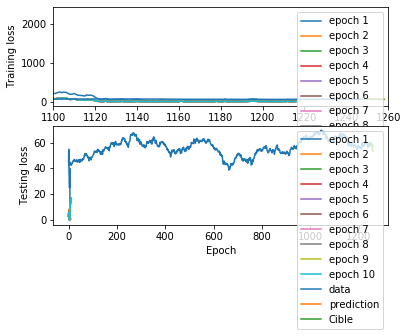

In [42]:
importlib.reload(SeriesNetTrainTestManager)
importlib.reload(seriesNet_torch)
myModels = [seriesNet_torch.seriesNet(1, nb_causal_block=5,gate_nb_filter=16, nb_block_dropped=3),
            seriesNet_torch.seriesNet(1, nb_causal_block=5,gate_nb_filter=16, nb_block_dropped=3)]
for model in myModels:
    model.float()

manager = SeriesNetTrainTestManager.TrainTestManager( 
                    myModels,
                    dataset_train,
                    dataset_validation,
                    lr=0.001,
                    batch_size=10)

index = random.randint(0,399)
manager.train_1company(10, index, pts_2pred = 10)
manager.plot_prediction(index, 0, pts_2pred = 10)
#manager.plot_prediction(index, 1, pts_2pred = 10)

(1, 30)


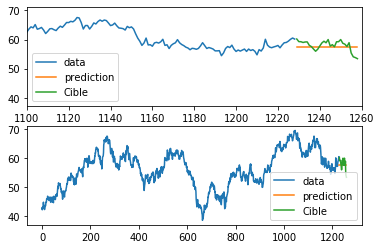

In [43]:
manager.plot_prediction(index, 0, pts_2pred = 30)

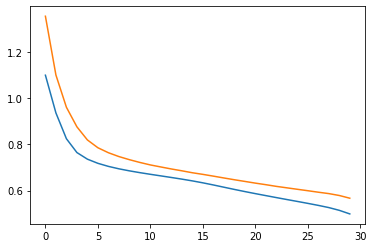

In [132]:
plt.plot(valid_loss_epoch)
plt.plot(training_loss_epoch)

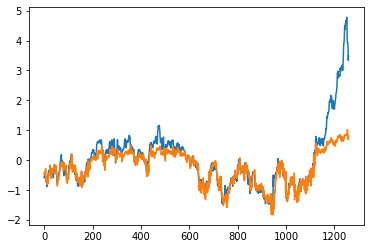

In [154]:
X=dataset_validation[20].view(1,5,1259)
Y=myModel(X)

plt.plot(X.detach().numpy()[0][1])
plt.plot(Y.detach().numpy()[0][1])


1259
torch.Size([1, 5, 1254])


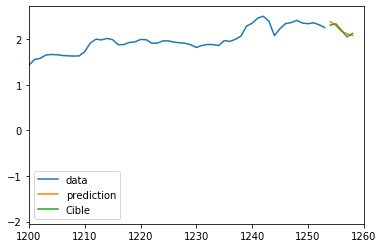

In [207]:
#On veut prédire les 15 prochains points d'une stock.
stockNb= random.randint(0,69)
P = 5
C, L = dataset_validation[stockNb].size()
print(L)
X=dataset_validation[stockNb].view(1,5,1259)
cible = dataset_validation[stockNb][:,L-P:].detach().numpy()
print(dataset_validation[stockNb].view(1,5,1259)[:,:,:L-P].size())
X=dataset_validation[stockNb].view(1,5,1259)[:,:,:L-P]
prediction=torch.zeros(1, 5, 1)
myModel.eval()
with torch.no_grad():
    input_data = X
    for i in range(P):
        input_data=myModel(input_data)
        prediction = torch.cat((prediction, input_data[:,:,-1].view(1,C,1)), 2)

prediction.size()
#prediction = torch.cat((X,(prediction[:,:,1:])), 2)
prediction = prediction[:,:,1:].detach().numpy()[0]
abscisse = np.arange(0,1259)
data=X.detach().numpy()[0]
#print(abscisse.shape, data[1].shape)
plt.plot(abscisse[:-P],data[1], label='data')
plt.plot(abscisse[-P:], prediction[1], label='prediction')
plt.plot(abscisse[-P:],cible[1],label ='Cible')
plt.xlim(1200,1260)
plt.legend()

In [95]:
#Strategie on predis les N_2Pred point et on s'entraine dessus 
# LES DATA DOIVENT ETRE DE LA FORME (N, C, TIMESERIES) OU N EST LE NOMBRE D'ELEMENTS DANS LA MINI BATCH
# C LE NOMBRE DE CANAUX, ET TIMESERIES LE NOMBRE DE POINTS DANS LA SERIE CHRONOLOGIQUE
# INITIALISER LE MODELE :
myModel = seriesNet_torch.seriesNet(5, nb_causal_block=5,gate_nb_filter=16, nb_block_dropped=2)
myModel = myModel.float()
N_2pred = 5
#dataset.float()
N, C, L = 10, 5, 1259
# CHOISIR UNE LOSS
criterion = nn.MSELoss()
optimizer = optim.SGD(myModel.parameters(), lr=0.001, weight_decay=0.01)
# TRACE DES METRICS
training_loss_epoch = []
valid_loss_epoch = []
#choice = torch.multinomial(torch.tensor(np.arange(data.size()[0])).float(), 1)
for i in range(20):
    print('epoch {}'.format(i+1))
    training_loss = []
    for j,batch in enumerate(training_loader):
        inputModel, target = batch[:,:,:L-N_2pred], batch[:,:,-N_2pred:]
        for k in range(N_2pred):
            output = myModel(inputModel)
            inputModel= torch.cat((inputModel,output[:,:,-1].view(10,5,1)),2)
        optimizer.zero_grad()
        #On calcul la loss par rapport a la derniere prediction
        loss = criterion(inputModel[:,:,-N_2pred:], target)
        loss.backward()
        optimizer.step()
        #inputModel= torch.cat((inputModel,output[:,:,-1].view(10,5,1)),2)
        training_loss.append(loss.item())
    training_loss_epoch.append(np.mean(training_loss))
    myModel.eval()
    with torch.no_grad():
        valid_loss=[]
        for batch in valid_loader:
            inputModel, target = batch[:,:,:L-N_2pred], batch[:,:,-N_2pred:]
            for k in range(N_2pred):
                output = myModel(inputModel)
                inputModel= torch.cat((inputModel,output[:,:,-1].view(10,5,1)),2)
            #output = myModel(inputModel)
            loss = criterion(inputModel[:,:,-N_2pred:], target)
            valid_loss.append(loss.item())
        valid_loss_epoch.append(np.mean(valid_loss))
    print('Validation loss %.3f' % (valid_loss_epoch[-1]))
    myModel.train()



epoch 1
Validation loss 1.027
epoch 2
Validation loss 0.616
epoch 3
Validation loss 0.528
epoch 4
Validation loss 0.502
epoch 5
Validation loss 0.488
epoch 6
Validation loss 0.484
epoch 7
Validation loss 0.477
epoch 8
Validation loss 0.472
epoch 9
Validation loss 0.470
epoch 10
Validation loss 0.464
epoch 11
Validation loss 0.461
epoch 12
Validation loss 0.459
epoch 13
Validation loss 0.456
epoch 14
Validation loss 0.452
epoch 15
Validation loss 0.450
epoch 16
Validation loss 0.447
epoch 17
Validation loss 0.444
epoch 18
Validation loss 0.441
epoch 19
Validation loss 0.442
epoch 20
Validation loss 0.436


1259
torch.Size([1, 5, 1254])


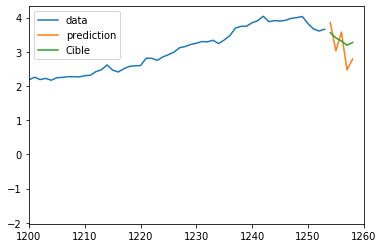

In [103]:
#On veut prédire les P prochains points d'une stock.
stockNb= random.randint(0,69)
P = 5
C, L = dataset_validation[stockNb].size()
print(L)
X=dataset_validation[stockNb].view(1,5,1259)
cible = dataset_validation[stockNb][:,L-P:].detach().numpy()
print(dataset_validation[stockNb].view(1,5,1259)[:,:,:L-P].size())
X=dataset_validation[stockNb].view(1,5,1259)[:,:,:L-P]
prediction=torch.zeros(1, 5, 1)
with torch.no_grad():
    input_data = X
    for i in range(P):
        input_data=myModel(input_data)
        prediction = torch.cat((prediction, input_data[:,:,-1].view(1,C,1)), 2)

prediction.size()
#prediction = torch.cat((X,(prediction[:,:,1:])), 2)
prediction = prediction[:,:,1:].detach().numpy()[0]
abscisse = np.arange(0,1259)
data=X.detach().numpy()[0]
#print(abscisse.shape, data[1].shape)
plt.plot(abscisse[:-P],data[1], label='data')
plt.plot(abscisse[-P:], prediction[1], label='prediction')
plt.plot(abscisse[-P:],cible[1],label ='Cible')
plt.xlim(1200,1260)
plt.legend()


In [226]:
2**4


16

In [243]:
conv0 = nn.Conv1d(in_channels=5, out_channels=5,
                kernel_size=2, stride=1, padding=0,dilation=1, bias=False)
conv1 = nn.Conv1d(in_channels=5, out_channels=5,
                kernel_size=2, stride=1, padding=0,dilation=2, bias=False)
conv2 = nn.Conv1d(in_channels=5, out_channels=5,
                kernel_size=2, stride=1, padding=0,dilation=4, bias=False)
conv3 = nn.Conv1d(in_channels=5, out_channels=5,
                kernel_size=2, stride=1, padding=0,dilation=8, bias=False)
conv4 = nn.Conv1d(in_channels=5, out_channels=5,
                kernel_size=2, stride=1, padding=0,dilation=16, bias=False)
X = torch.randn(10,5,1+2+4+8+16+1)
conv4(conv3(conv2(conv1(conv0(X))))).size()

torch.Size([10, 5, 1])

1259
torch.Size([5, 1254])
1222


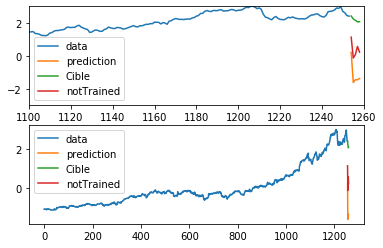

In [44]:
stockNb= random.randint(0,399)
P = 5
C, L = dataset_train[stockNb].size()
print(L)
start=1+2+4+8+16+1
myModel = seriesNet(5, nb_causal_block=5,gate_nb_filter=16, nb_block_dropped=2)
myModel = myModel.float()
print(dataset_train[stockNb][:,:L-P].size())
X=dataset_train[stockNb][:,:L-P].view(1,5,L-P)
pred_not_trained=torch.zeros(1, 5, 1)
with torch.no_grad():
    input_data = X
    for i in range(P):
        input_data=myModel(input_data)
        pred_not_trained = torch.cat((pred_not_trained, input_data[:,:,-1].view(1,C,1)), 2)

criterion = nn.MSELoss()
optimizer = optim.SGD(myModel.parameters(), lr=0.001, weight_decay=0.01)
print(L-P-start)
for i in range(L-P-start):
    pred=torch.zeros(1, 5, 1)
    input_data = X[:,:,i:start+i]
    for i in range(P):
        input_data=myModel(input_data)
        pred = torch.cat((pred, input_data[:,:,-1].view(1,C,1)), 2)
    #output = myModel(X[:,:,i:start+i])
    cible = X[:,:,start+i:start+i+P]
    optimizer.zero_grad()
    #On calcul la loss par rapport a la derniere prediction
    loss = criterion(pred[:,:,1:], cible)
    loss.backward()
    #print(loss.item())
    optimizer.step()
        
    
#cible = dataset_validation[stockNb][:,L-P:].detach().numpy()
#print(dataset_validation[stockNb].view(1,5,1259)[:,:,:L-P].size())
#X=dataset_validation[stockNb].view(1,5,1259)[:,:,:L-P]

cible=dataset_train[stockNb][:,L-P:].detach().numpy()
prediction=torch.zeros(1, 5, 1)
with torch.no_grad():
    input_data = X
    for i in range(P):
        input_data=myModel(input_data)
        prediction = torch.cat((prediction, input_data[:,:,-1].view(1,C,1)), 2)


prediction.size()
#prediction = torch.cat((X,(prediction[:,:,1:])), 2)
prediction = prediction[:,:,1:].detach().numpy()[0]
pred_not_trained =pred_not_trained[:,:,1:].detach().numpy()[0]
abscisse = np.arange(0,1259)
data=X.detach().numpy()[0]
#print(abscisse.shape, data[1].shape)
plt.subplot(211)
plt.plot(abscisse[:-P],data[1], label='data')
plt.plot(abscisse[-P:], prediction[1], label='prediction')
plt.plot(abscisse[-P:],cible[1],label ='Cible')
plt.plot(abscisse[-P:],pred_not_trained[1],label ='notTrained')
plt.xlim(1100,1260)
plt.ylim(-3,3)
plt.legend()
plt.subplot(212)
plt.plot(abscisse[:-P],data[1], label='data')
plt.plot(abscisse[-P:], prediction[1], label='prediction')
plt.plot(abscisse[-P:],cible[1],label ='Cible')
plt.plot(abscisse[-P:],pred_not_trained[1],label ='notTrained')

#plt.xlim(1200,1260)
plt.legend()


In [54]:
# Sliding window sur tout le dataset
#stockNb= random.randint(0,399)
N_2pred = 5
C, L = dataset_train[stockNb].size()
print(L)
start=1+2+4+8+16+1
myModel = seriesNet(5, nb_causal_block=5,gate_nb_filter=16, nb_block_dropped=2)
myModel = myModel.float()
#print(dataset_train[stockNb][:,:L-P].size())
#X=dataset_train[stockNb][:,:L-P].view(1,5,L-P)
criterion = nn.MSELoss()
optimizer = optim.SGD(myModel.parameters(), lr=0.001, weight_decay=0.01)


training_loss_epoch = []
valid_loss_epoch = []
#choice = torch.multinomial(torch.tensor(np.arange(data.size()[0])).float(), 1)
for i in range(5):
    print('epoch {}'.format(i+1))
    training_loss = []
    for j,batch in enumerate(training_loader):
        print('batch {}/{}'.format(j,len(training_loader)))
        inputModel, target = batch[:,:,:L-N_2pred], batch[:,:,-N_2pred:]
        for k in range(L-P-start):
            pred=torch.zeros(10, 5, 1)
            input_data = inputModel[:,:,i:start+i]
            for r in range(P):
                input_data=myModel(input_data)
                #print(pred.size())
                #print(input_data[:,:,-1].view(10,C,1).size())
                pred = torch.cat((pred, input_data[:,:,-1].view(10,C,1)), 2)
            #output = myModel(X[:,:,i:start+i])
            #print(pred.size())
            cible = inputModel[:,:,start+i:start+i+P]
            #print(cible.size())
            optimizer.zero_grad()
            #On calcul la loss par rapport a la derniere prediction
            loss = criterion(pred[:,:,1:], cible)
            loss.backward()
            #print(loss.item())
            optimizer.step()
            #inputModel= torch.cat((inputModel,output[:,:,-1].view(10,5,1)),2)
            training_loss.append(loss.item())
    training_loss_epoch.append(np.mean(training_loss))
    myModel.eval()
    with torch.no_grad():
        valid_loss=[]
        for batch in valid_loader:
            inputModel, target = batch[:,:,:L-N_2pred], batch[:,:,-N_2pred:]
            for k in range(N_2pred):
                output = myModel(inputModel)
                inputModel= torch.cat((inputModel,output[:,:,-1].view(10,5,1)),2)
            #output = myModel(inputModel)
            loss = criterion(inputModel[:,:,-N_2pred:], target)
            valid_loss.append(loss.item())
        valid_loss_epoch.append(np.mean(valid_loss))
    print('Validation loss %.3f' % (valid_loss_epoch[-1]))
    myModel.train()



  
stockNb= random.randint(0,399)
X=dataset_train[stockNb][:,:L-P]
cible=dataset_train[stockNb][:,L-P:].detach().numpy()
prediction=torch.zeros(1, 5, 1)
with torch.no_grad():
    input_data = X
    for i in range(P):
        input_data=myModel(input_data)
        prediction = torch.cat((prediction, input_data[:,:,-1].view(1,C,1)), 2)


prediction.size()
#prediction = torch.cat((X,(prediction[:,:,1:])), 2)
prediction = prediction[:,:,1:].detach().numpy()[0]
pred_not_trained =pred_not_trained[:,:,1:].detach().numpy()[0]
abscisse = np.arange(0,1259)
data=X.detach().numpy()[0]
#print(abscisse.shape, data[1].shape)
plt.subplot(211)
plt.plot(abscisse[:-P],data[1], label='data')
plt.plot(abscisse[-P:], prediction[1], label='prediction')
plt.plot(abscisse[-P:],cible[1],label ='Cible')
plt.xlim(1100,1260)
plt.ylim(-3,3)
plt.legend()
plt.subplot(212)
plt.plot(abscisse[:-P],data[1], label='data')
plt.plot(abscisse[-P:], prediction[1], label='prediction')
plt.plot(abscisse[-P:],cible[1],label ='Cible')

#plt.xlim(1200,1260)
plt.legend()


1259
epoch 1
batch 0/40
batch 1/40
batch 2/40
batch 3/40
batch 4/40
batch 5/40
batch 6/40
batch 7/40
batch 8/40
batch 9/40
batch 10/40
batch 11/40
batch 12/40
batch 13/40
batch 14/40
batch 15/40
batch 16/40
batch 17/40
batch 18/40
batch 19/40
batch 20/40
batch 21/40
batch 22/40
batch 23/40
batch 24/40
batch 25/40
batch 26/40
batch 27/40
batch 28/40
batch 29/40
batch 30/40
batch 31/40
batch 32/40
batch 33/40
batch 34/40
batch 35/40
batch 36/40
batch 37/40
batch 38/40
batch 39/40


NameError: name 'valid_loader' is not defined

<class 'int'>
<class 'int'> <class 'int'>
32


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 of 10


 10%|█         | 1/10 [00:06<01:00,  6.71s/it]

Epoch: 2 of 10


 20%|██        | 2/10 [00:12<00:52,  6.54s/it]

Epoch: 3 of 10


 30%|███       | 3/10 [00:20<00:48,  6.98s/it]

Epoch: 4 of 10


 40%|████      | 4/10 [00:26<00:39,  6.59s/it]

Epoch: 5 of 10


 50%|█████     | 5/10 [00:32<00:32,  6.52s/it]

Epoch: 6 of 10


 60%|██████    | 6/10 [00:39<00:26,  6.67s/it]

Epoch: 7 of 10


 70%|███████   | 7/10 [00:46<00:19,  6.54s/it]

Epoch: 8 of 10


 80%|████████  | 8/10 [00:53<00:13,  6.91s/it]

Epoch: 9 of 10


 90%|█████████ | 9/10 [01:01<00:07,  7.00s/it]

Epoch: 10 of 10


100%|██████████| 10/10 [01:07<00:00,  6.74s/it]


10


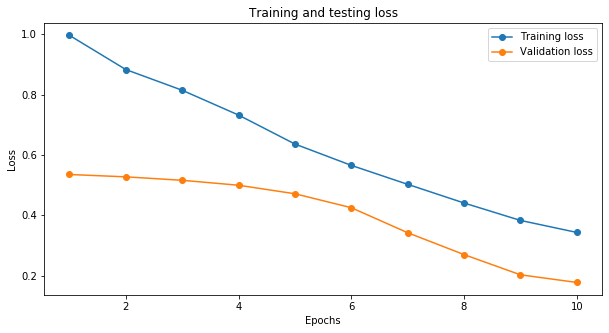

(5, 10)


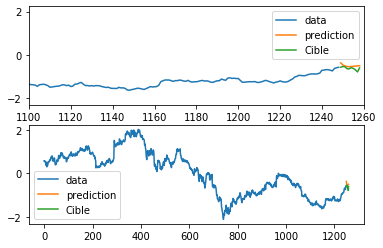

In [46]:
importlib.reload(SeriesNetTrainTestManager)
importlib.reload(seriesNet_torch)
myModel = seriesNet_torch.seriesNet(5, nb_causal_block=5,gate_nb_filter=16, nb_block_dropped=2)
myModel = myModel.float()
criterion = nn.MSELoss()
optimizer = optim.SGD(myModel.parameters(), lr=0.0001, weight_decay=0.01)
#dataset_train.float()
manager = SeriesNetTrainTestManager.TrainTestManager( myModel,
                                 dataset_train,
                                 dataset_validation,
                                 criterion,
                                 optimizer,
                                 batch_size=10)

index = random.randint(0,399)
manager.train_strategieB( epochs=10, data_index=index, pts_2pred = 10)
manager.plot_metrics()
manager.plot_prediction(index, 1, pts_2pred = 10)

(5, 20)


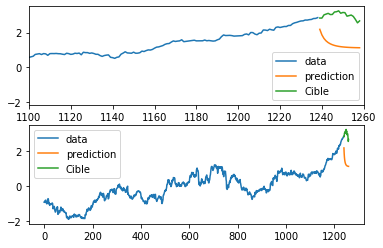

In [44]:
index = random.randint(0,399)
manager.plot_prediction(index, 1, pts_2pred = 20)

In [29]:
(2*np.ones(5)) ** np.arange(5)

array([ 1.,  2.,  4.,  8., 16.])

<class 'int'>
<class 'int'> <class 'int'>
32


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 of 5


 20%|██        | 1/5 [00:09<00:36,  9.14s/it]

Epoch: 2 of 5


 40%|████      | 2/5 [00:17<00:26,  8.93s/it]

Epoch: 3 of 5


 60%|██████    | 3/5 [00:26<00:17,  8.86s/it]

Epoch: 4 of 5


 80%|████████  | 4/5 [00:34<00:08,  8.70s/it]

Epoch: 5 of 5


100%|██████████| 5/5 [00:43<00:00,  8.66s/it]


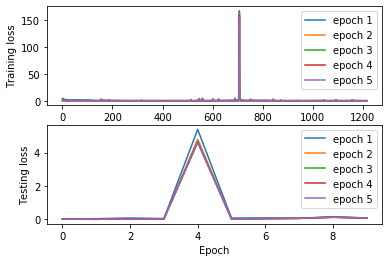

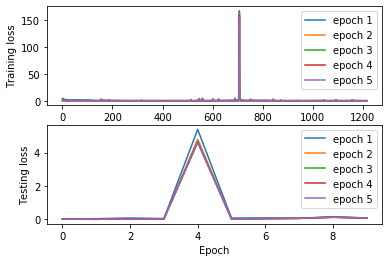

In [11]:
importlib.reload(SeriesNetTrainTestManager)
importlib.reload(seriesNet_torch)
myModels = [seriesNet_torch.seriesNet(5, nb_causal_block=5,gate_nb_filter=16, nb_block_dropped=2),
            seriesNet_torch.seriesNet(5, nb_causal_block=5,gate_nb_filter=16, nb_block_dropped=2)]
for model in myModels:
    model.float()

manager = SeriesNetTrainTestManager.TrainTestManager( 
                    myModels,
                    dataset_train,
                    dataset_validation,
                    lr=0.001,
                    batch_size=10)

#index = random.randint(0,399)
index = random.randint(0,399)
manager.train(5,index, pts_2pred=10)
manager.plot_Train_metrics()

#manager.plot_metrics()
#manager.plot_prediction(index, 1, pts_2pred = 10)

(5, 30)


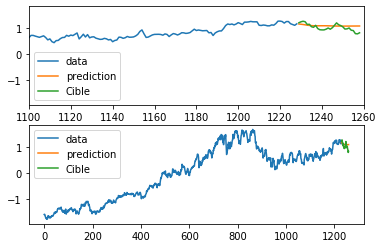

In [14]:
manager.plot_prediction(index, 3, pts_2pred = 30)

Epoch: 1 of 2
Epoch: 2 of 2


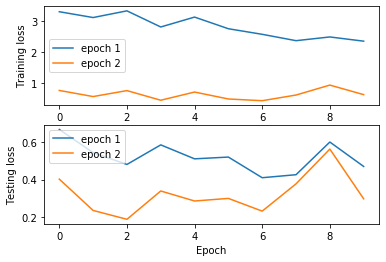

In [5]:
importlib.reload(SeriesNetTrainTestManager)
importlib.reload(seriesNet_torch)
myModels = [seriesNet_torch.seriesNet(5, nb_causal_block=5,gate_nb_filter=16, nb_block_dropped=2),
            seriesNet_torch.seriesNet(5, nb_causal_block=5,gate_nb_filter=16, nb_block_dropped=2)]
for model in myModels:
    model.float()

manager = SeriesNetTrainTestManager.TrainTestManager( 
                    myModels,
                    dataset_train,
                    dataset_validation,
                    lr=0.001,
                    batch_size=10)

#index = random.randint(0,399)
manager.pretrain(num_epochs=2, pts_2pred = 10)

#manager.plot_metrics()
#manager.plot_prediction(index, 1, pts_2pred = 10)

<class 'int'>
<class 'int'> <class 'int'>
32


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 of 5


 20%|██        | 1/5 [00:09<00:36,  9.23s/it]

Epoch: 2 of 5


 40%|████      | 2/5 [00:18<00:27,  9.13s/it]

Epoch: 3 of 5


 60%|██████    | 3/5 [00:27<00:18,  9.10s/it]

Epoch: 4 of 5


 80%|████████  | 4/5 [00:36<00:09,  9.16s/it]

Epoch: 5 of 5


100%|██████████| 5/5 [00:45<00:00,  9.05s/it]


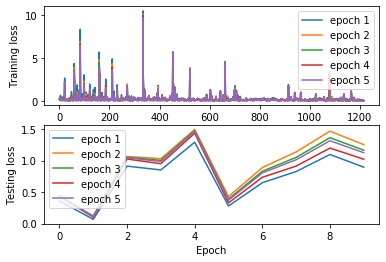

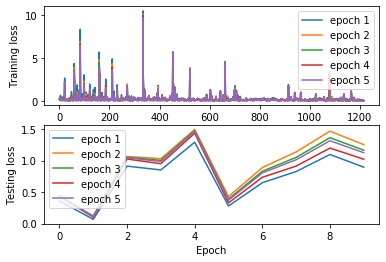

In [7]:
index = random.randint(0,399)
manager.train(5,index, pts_2pred=10)
manager.plot_Train_metrics()
#manager.plot_metrics()
#manager.plot_prediction(index, 1, pts_2pred = 10)

In [90]:
for param1, param2 in zip(manager.model.parameters(),manager.pre_trained_model.parameters()):
    print(param1.data == param2.data)

tensor([[[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [F

         [False]]])
tensor([[[False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         [False],
         [False],
         [False],
  

         [False, False]]])
tensor([[[False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         [False],
         [False],
         [Fal

         [False]]])


In [84]:
print(manager.model.parameters())
print(manager.pre_trained_model.parameters())
myModels = [seriesNet_torch.seriesNet(5, nb_causal_block=5,gate_nb_filter=16, nb_block_dropped=2),
            seriesNet_torch.seriesNet(5, nb_causal_block=5,gate_nb_filter=16, nb_block_dropped=2)]
print(myModels[0].parameters())
print(myModels[1].parameters())

for param1, param2 in zip(manager.model.parameters(),manager.pre_trained_model.parameters()):
    print(param1.data == param2.data)


<generator object Module.parameters at 0x0000016A13AD04C8>
<generator object Module.parameters at 0x0000016A13AD04C8>
<generator object Module.parameters at 0x0000016A13AD04C8>
<generator object Module.parameters at 0x0000016A13AD04C8>
tensor([[[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, 

         [True]]])
tensor([[[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],

         [True]]])
tensor([[[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],
         [True, True],
         [True, True],
         [True, True]],

        [[True, True],
         [True, True],

<class 'int'>
<class 'int'> <class 'int'>
32


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 of 10


 10%|█         | 1/10 [00:10<01:30, 10.10s/it]

Epoch: 2 of 10


 20%|██        | 2/10 [00:20<01:22, 10.25s/it]

Epoch: 3 of 10


 30%|███       | 3/10 [00:30<01:10, 10.03s/it]

Epoch: 4 of 10


 40%|████      | 4/10 [00:39<00:59,  9.92s/it]

Epoch: 5 of 10


 50%|█████     | 5/10 [00:50<00:50, 10.18s/it]

Epoch: 6 of 10


 60%|██████    | 6/10 [01:01<00:41, 10.30s/it]

Epoch: 7 of 10


 70%|███████   | 7/10 [01:11<00:30, 10.30s/it]

Epoch: 8 of 10


 80%|████████  | 8/10 [01:22<00:20, 10.47s/it]

Epoch: 9 of 10


 90%|█████████ | 9/10 [01:32<00:10, 10.44s/it]

Epoch: 10 of 10


100%|██████████| 10/10 [01:43<00:00, 10.35s/it]


15


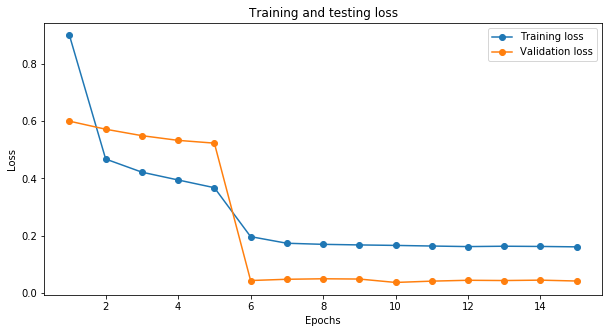

(5, 10)


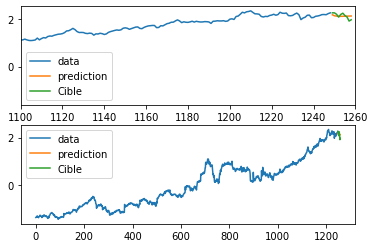

In [85]:
index = random.randint(0,399)
manager.train_strategieB( epochs=10, data_index=index, pts_2pred = 10)
manager.plot_metrics()
manager.plot_prediction(index, 1, pts_2pred = 10)

In [86]:
for param1, param2 in zip(manager.model.parameters(),manager.pre_trained_model.parameters()):
    print(param1.data == param2.data)


tensor([[[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [False, False]],

        [[False, False],
         [False, False],
         [False, False],
         [False, False],
         [F

         [False]]])
tensor([[[False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         [False],
         [False],
         [False],
  

         [False, False]]])
tensor([[[False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         [False],
         [False],
         [Fal

         [False]]])


In [132]:
a= np.arange(10)
b= np.arange(10)
c= np.arange(10)
d = np.array([a,b,c])
d.shape

(3, 10)

In [129]:
a=[1,2,3,4,5,6,7,8,9,10]
b=np.array(a).reshape(1,10)
b.shape

(1, 10)

In [44]:
import fn_500_dataset

train_window :  torch.Size([940, 1, 64])
target_train :  torch.Size([940, 1, 1])
eval_train :  torch.Size([235, 1, 64])
eval_target :  torch.Size([235, 1, 1])
test_input :  torch.Size([1, 1, 64])
test_target :  torch.Size([1, 1, 20])
235
940
epoch 0/ 7
epoch 1/ 7
epoch 2/ 7
epoch 3/ 7
epoch 4/ 7
epoch 5/ 7
epoch 6/ 7


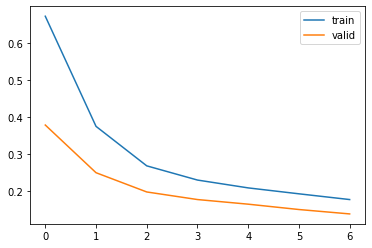

In [31]:
#importlib.reload(fn_500_dataset)
#importlib.reload(seriesNet_torch)
#dataset=fn_500_dataset.slidingWindowDataset(60,action_name='ABBV_data',axis='volume',normalise=False)
model = seriesNet_torch.seriesNet(1, nb_causal_block=6,gate_nb_filter=16, nb_block_dropped=2)
model.float()
N = model.get_pts_for_Pred()
pts_2_pred = 20
dataset_train, dataset_eval, test_input, test_target = fn_500_dataset.create_sliding_dataset(N,
                                                                    pts_2_pred = pts_2_pred,
                                                                    action_name='AAPL_data',
                                                                    axis='open',
                                                                    normalise=True)

dataset_train.float()
dataset_eval.float()

train_loader = DataLoader(dataset_train, batch_size=10, shuffle=False, drop_last=False)
valid_loader = DataLoader(dataset_eval, batch_size=10, shuffle=False, drop_last=False)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=0.01)

#input_, target = dataset_train[1]
#input_, target = input_.view(1,1,64).float(), target.view(1,1,1).float() 

#target = torch.cat((input_[:,:,1:],target),axis=2)
#model.eval()
#output = model(input_)

#optimizer.zero_grad()
#loss=criterion(output, target)
#loss=criterion(output[:,:,-1].view(1,1,1), target)

#print('loss : ',loss.item())
#loss.backward()
#print(model.module_block[-2].conv.weight.grad) 

#model.train()
#print(output.size())
loss_epoch = []
loss_eval_epoch = []
for epoch in range(7):
    print('epoch {}/ 7'.format(epoch))
    losses = []
    for data, target in train_loader:
        N,C,W = data.size()
        output = model(data)
        optimizer.zero_grad()
        #loss=criterion(output, target)
        loss=criterion(output[:,:,-1].view(N,C,1), target)
        #print('loss : ',loss.item())
        loss.backward()
        optimizer.step()
        #print(model.module_block[-2].conv.weight.grad) 
        losses.append(loss.item())
    loss_epoch.append(np.mean(losses))
    
    model.eval()
    
    with torch.no_grad():
        losses = []
        for data, target in valid_loader:
            N,C,W = data.size()
            output = model(data)
            loss = criterion(output[:, :, -1].view(N,C,1), target)
            losses.append(loss.item())
    loss_eval_epoch.append(np.mean(losses))
    model.train()

plt.figure()
plt.plot(loss_epoch, label='train')
plt.plot(loss_eval_epoch, label='valid')
plt.legend()

torch.Size([1, 1, 64])
tensor([[2.1394]])
tensor([[[False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False,  True, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False]]])
torch.Size([1, 1, 64])
tensor([[2.1522]])
tensor([[[False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False,  True, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, Fa

          False, False, False, False]]])
torch.Size([1, 1, 64])
tensor([[2.3162]])
tensor([[[False, False, False, False, False, False, False, False,  True, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False]]])
torch.Size([1, 1, 64])
tensor([[2.3345]])
tensor([[[False, False, False, False, False, False, False,  True, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, False, False, False, False, False, False, False,
          False, False, False, Fal

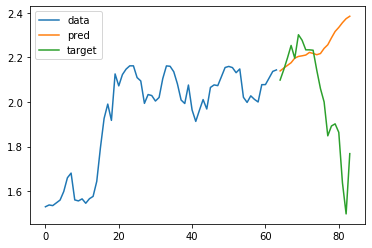

In [32]:
#print(test_input.size())
#print(test_target.size())
model.eval()
_, C, P = test_target.size()
X = test_input.float().clone()
with torch.no_grad():
    pred = []
    for p in range(P):
        output = model(X)
        print(X.size())
        print(output[:,:,-1])
        print(X == torch.cat((X[:,:,1:],output[:,:,-1].view(1,C,1)),axis= 2))
        X = torch.cat((X[:,:,1:],output[:,:,-1].view(1,C,1)),axis= 2)
        pred.append(output[:,:,-1].view(1).item())
pred = np.array(pred)
model.train()

#plt.figure()
absicse = np.arange(0,64+pts_2_pred)
data = test_input.float().view(64).detach().numpy()
target_ = test_target.float().view(pts_2_pred).detach().numpy()
print(pred.shape)
print(absicse.shape)
print(data.shape)
plt.plot(absicse[:64],data, label='data')
plt.plot(absicse[64:], pred, label='pred')
plt.plot(absicse[64:], target_, label='target')
plt.legend()

In [18]:
model = model.seriesNet_torch.seriesNet(1, nb_causal_block=8,gate_nb_filter=16, nb_block_dropped=2)


AttributeError: 'seriesNet' object has no attribute 'seriesNet_torch'

In [17]:
importlib.reload(data_set.fn_500_dataset)
importlib.reload(model.seriesNet_torch)
importlib.reload(CausalTrainTest)
#dataset=fn_500_dataset.slidingWindowDataset(60,action_name='ABBV_data',axis='volume',normalise=False)
model = model.seriesNet_torch.seriesNet(1, nb_causal_block=8,gate_nb_filter=16, nb_block_dropped=2)
model.float()
N = model.get_pts_for_Pred()
pts_2_pred = 20
dataset_train, dataset_eval, test_input, test_target = data_set.fn_500_dataset.create_sliding_dataset(N,
                                                                    pts_2_pred = pts_2_pred,
                                                                    action_name='AAPL_data',
                                                                    axis='open',
                                                                    normalise=True)

train_loader = DataLoader(dataset_train, batch_size=10, shuffle=False, drop_last=False)
valid_loader = DataLoader(dataset_eval, batch_size=10, shuffle=False, drop_last=False)


manager =CausalTrainTest.TrainManager( model,
                     train_loader,
                     valid_loader,
                     lr=0.001,
                     loss_fn = 'MeanSquared',
                     optimizer_type='sgd',
                     pts_2pred = 10)

manager.train(7)
manager.plot_prediction(test_input, test_target, pts_2_pred)


AttributeError: 'seriesNet' object has no attribute 'seriesNet_torch'

In [13]:
# LES DATA DOIVENT ETRE DE LA FORME (N, C, TIMESERIES) OU N EST LE NOMBRE D'ELEMENTS DANS LA MINI BATCH
# C LE NOMBRE DE CANAUX, ET TIMESERIES LE NOMBRE DE POINTS DANS LA SERIE CHRONOLOGIQUE
# INITIALISER LE MODELE :
myModel = seriesNet(5, nb_causal_block=5,gate_nb_filter=16, nb_block_dropped=2)
myModel = myModel.float()
#dataset.float()
# CHOISIR UNE LOSS
criterion = nn.MSELoss()
optimizer = optim.SGD(myModel.parameters(), lr=0.001, weight_decay=0.01)
# TRACE DES METRICS
training_loss_epoch = []
valid_loss_epoch = []
#choice = torch.multinomial(torch.tensor(np.arange(data.size()[0])).float(), 1)
for i in range(30):
    print('epoch {}'.format(i+1))
    training_loss = []
    for j,batch in enumerate(training_loader):
        inputModel, target = batch[:,:,:-1], batch[:,:,1:]
        output = myModel(inputModel)
        optimizer.zero_grad()
        loss = criterion(output, target)
        loss.backward()
        #print(" loss : ", loss)
        optimizer.step()
        training_loss.append(loss.item())
        #print(training_loss)
    training_loss_epoch.append(np.mean(training_loss))
    myModel.eval()
    with torch.no_grad():
        valid_loss=[]
        for batch in valid_loader:
            inputModel, target = batch[:,:,:-1], batch[:,:,1:]
            output = myModel(inputModel)
            loss = criterion(output, target)
            valid_loss.append(loss.item())
        valid_loss_epoch.append(np.mean(valid_loss))
    print('Validation loss %.3f' % (valid_loss_epoch[-1]))
    myModel.train()

TypeError: super(type, obj): obj must be an instance or subtype of type

In [105]:
torch.zeros(1154,1,60)[1].size()

torch.Size([1, 60])

In [106]:
int(20*1124/100)

224